Found 15000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2355s 5s/step - accuracy: 0.8171 - loss: 0.5551 - val_accuracy: 0.9550 - val_loss: 0.1390
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2024s 4s/step - accuracy: 0.9649 - loss: 0.1158 - val_accuracy: 0.9656 - val_loss: 0.1026
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1969s 4s/step - accuracy: 0.9711 - loss: 0.0879 - val_accuracy: 0.9658 - val_loss: 0.0879
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1981s 4s/step - accuracy: 0.9794 - loss: 0.0702 - val_accuracy: 0.9734 - val_loss: 0.0737
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2031s 4s/step - accuracy: 0.9770 - loss: 0.0643 - val_accuracy: 0.9774 - val_loss: 0.0659
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2066s 4s/step - accuracy: 0.9818 - loss: 0.0558 - val_accuracy: 0.9808 - val_loss: 0.0604
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2025s 4s/step - accuracy: 0.9845 - loss: 0.0490 - val_accuracy: 0.9816 - val_loss: 0.0559
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2047s 4s/step - accuracy: 0.9868 - loss: 0.0437 - 

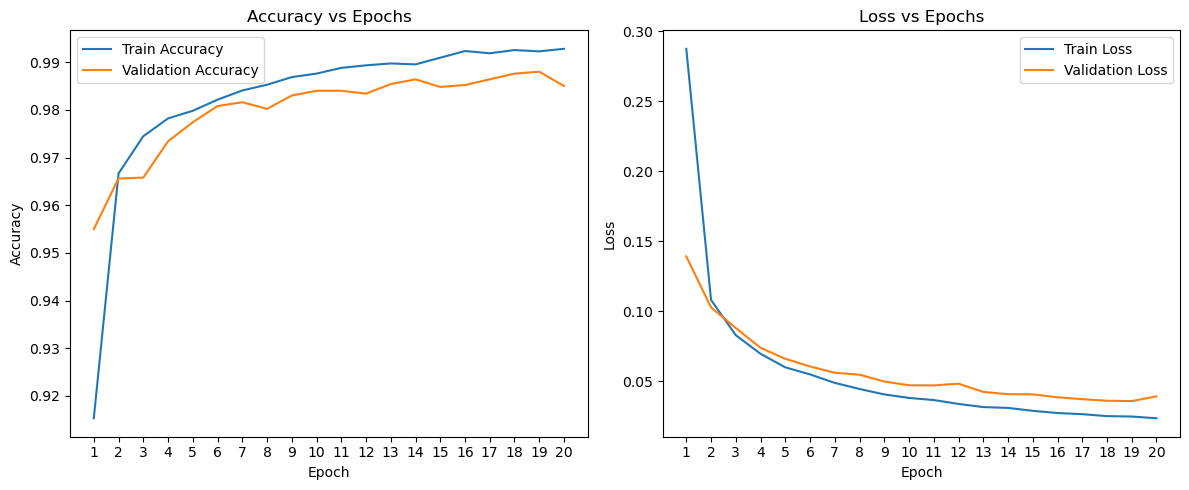

157/157 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step
Classification Report:
               precision    recall  f1-score   support

   colon_aca     0.9990    0.9940    0.9965      1000
     colon_n     0.9990    0.9990    0.9990      1000
    lung_aca     0.9416    0.9830    0.9618      1000
      lung_n     1.0000    0.9990    0.9995      1000
    lung_scc     0.9813    0.9440    0.9623      1000

    accuracy                         0.9838      5000
   macro avg     0.9842    0.9838    0.9838      5000
weighted avg     0.9842    0.9838    0.9838      5000



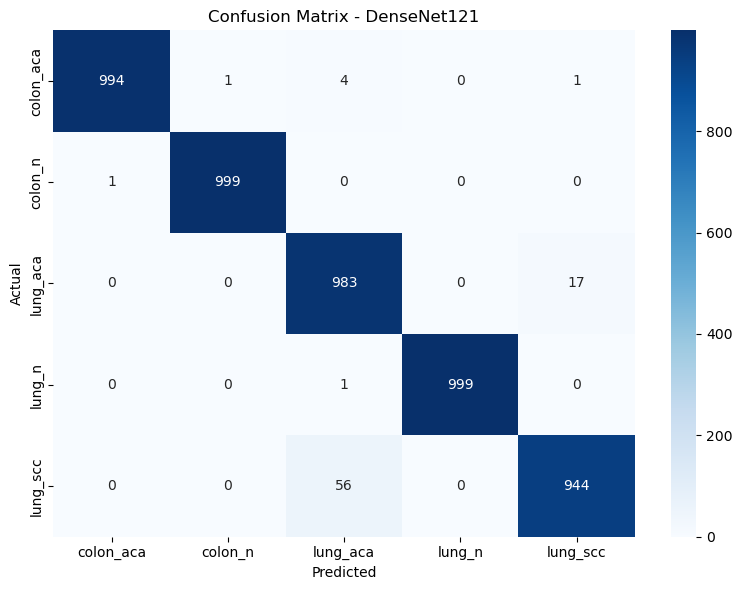

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

# === Configuration ===
dataset_dir = 'combined_dataset1'
img_size = (224, 224)
batch_size = 32
epochs = 20

# === Data Generators ===
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# === Save Class Indices ===
with open('class_indices_densenet.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

# === Build Model ===
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Save Best Model Callback ===
checkpoint = ModelCheckpoint('densenet121_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# === Train Model ===
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

# === Plot Accuracy & Loss ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'], label='Train Accuracy')
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'], label='Train Loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

# === Evaluate on Test Set ===
test_generator.reset()
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Classification Report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report:\n", report)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DenseNet121')
plt.tight_layout()
plt.show()
